In [1]:
from functools import partial

import datetime
import gc
import lightgbm as lgb
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sns.set()

%matplotlib inline

In [2]:
def seed_everything(seed=13):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    
def read_from_disk(path, filename):
    with open(os.path.join(path, filename), 'rb') as handle:
        return pickle.load(handle)
    
    
def save_to_disk(obj, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
def split_features_by_importance(x_train, x_val, y_val, model, importance_tresh=0.1, permut_tresh=1e-4):
    all_features = x_train.columns
    feature_importance = calc_feature_importance(all_features, model)
    garbage_features = find_garbage_features(feature_importance, importance_tresh)
    retain_features = find_features_to_retain(garbage_features, x_val, y_val, model, threshold=permut_tresh)
    remove_features = set(garbage_features) - set(retain_features)
    return list(set(all_features) - remove_features), list(remove_features), feature_importance


def calc_feature_importance(features, model):
    importance = pd.DataFrame([
        list(features),
        model.feature_importance(importance_type='split').tolist(),
        model.feature_importance(importance_type='gain').tolist()
    ]).T
    importance.columns = ['feature', 'split', 'gain']
    return importance


def find_garbage_features(importance, treshold):
    min_gain = importance['gain'].quantile(treshold)
    min_split = importance['split'].quantile(treshold)
    garbage_features = importance[ 
        (importance['split'] < min_split) # | (importance['gain'] < min_gain) 
    ]['feature']
    return list(garbage_features)


def find_features_to_retain(features, x, y, model, threshold=1e-4):
    scores = permutation_importance(x.copy(), y, model, columns=features)
    retain_features = [feat for feat, score in scores.items() if score < -threshold]
    return retain_features


def permutation_importance(x, y, model, base_score=None, columns=None): 
    diff = {}
    if not base_score:
        base_score = roc_auc_score(y, model.predict(x))
    if not columns:
        columns = x.columns
    for col in columns:
        value = x[col].copy()
        x[col] = np.random.permutation(x[col].values)
        diff[col] = roc_auc_score(y, model.predict(x)) - base_score
        x[col] = value
    return diff


def plot_feature_importance(model, max_features=50):
    f, ax = plt.subplots(1,2, figsize=[20,10])
    lgb.plot_importance(model, max_num_features=max_features, ax=ax[0], importance_type='gain')
    ax[0].set_title("Light GBM GAIN Feature Importance")

    lgb.plot_importance(model, max_num_features=max_features, ax=ax[1], importance_type='split')
    ax[1].set_title("Light GBM SPLIT Feature Importance")
    plt.tight_layout(pad=1)
    
    
def avg_feature_importance(dfs):
    temp = pd.concat(dfs).reset_index(drop=True)
    for col in ['split', 'gain']:
        temp[col] = temp[col].astype(float)
    agg = temp.groupby('feature').mean()
    return agg

# Data preparation

In [4]:
DFS_DIR = '../input/fraud-messing-v31'

In [5]:
df_train, y_train, df_val, y_val, df_hold, y_hold, df_test = map(partial(read_from_disk, DFS_DIR), [
    'df_train.pkl', 'y_train.pkl', 'df_val.pkl', 'y_val.pkl', 'df_hold.pkl', 'y_hold.pkl', 'df_test.pkl'
])

In [6]:
print(list(df_train.columns))

['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V

In [7]:
all_dfs = [df_train, df_val, df_hold, df_test]

In [8]:
def frequency(col, dfs):
    counts = pd.concat(map(lambda df: df[col], dfs), ignore_index=True).value_counts(dropna=False)
    return map(lambda df: df[col].map(counts), dfs)

# from https://www.kaggle.com/tolgahancepel/lightgbm-single-model-and-feature-engineering
def concat_features(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)
    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)
    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    return data

for df in all_dfs:
    df = concat_features(df)


freq_cols = ['card1','card2','card3','card5',
          'C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceType',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]
for col in freq_cols:
    for df, freq in zip(all_dfs, frequency(col, all_dfs)):
        df[col+'_count'] = freq


agg_cols = ['card1','card2','card3','card5', 'uid', 'uid2', 'uid3']  
for col in agg_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([df_train[[col, 'TransactionAmt']], df_val[[col, 'TransactionAmt']], df_hold[[col, 'TransactionAmt']], df_test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
        
        for df in all_dfs:
            df[new_col_name] = df[col].map(temp_df)
        del temp_df


encode_cols = ['uid', 'uid2', 'uid3']
for col in encode_cols:
    print('Encoding', col)
    temp_df = pd.concat([df_train[col], df_val[col], df_hold[col], df_test[col]])
    col_encoded = temp_df.value_counts().to_dict()
    del temp_df
    for df in all_dfs:
        df[col] = df[col].map(col_encoded)

Encoding uid
Encoding uid2
Encoding uid3


# Feature engineering

In [9]:
# initial_features = {
#     'C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 
#     'Cents', 'D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2', 'D3', 'D4', 'D5', 'D6', 
#     'D7', 'D8', 'D9', 'DayOfMonth', 'DayOfWeek', 'DeviceInfo', 'DeviceType', 'Hour', 
#     'IsMonthEnd', 'IsMonthStart', 'IsQuarterEnd', 'IsQuarterStart', 'M1', 'M2', 'M3', 'M4', 
#     'M5', 'M6', 'M7', 'M8', 'M9', 'MonthFraction', 'P_emaildomain', 'ProductCD', 'Quarter', 
#     'R_emaildomain', 'TransactionAmt', 'TransactionDT', 'V1', 'V10', 'V100', 'V101', 'V102', 
#     'V103', 'V104', 'V105', 'V106', 'V108', 'V109', 'V11', 'V110', 'V112', 'V114', 'V115', 
#     'V116', 'V12', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V13', 'V130', 
#     'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V139', 'V140', 'V141', 'V142', 
#     'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V15', 'V150', 'V151', 'V152', 
#     'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V16', 'V160', 'V161', 'V162', 'V163', 
#     'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V17', 'V170', 'V171', 'V172', 'V173', 
#     'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V18', 'V180', 'V181', 'V182', 'V183', 
#     'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V19', 'V190', 'V192', 'V193', 'V198', 
#     'V199', 'V2', 'V20', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 
#     'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 
#     'V219', 'V22', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
#     'V229', 'V23', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 
#     'V239', 'V24', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V25', 
#     'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V26', 
#     'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 
#     'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 
#     'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V29', 'V290', 'V291', 'V292', 
#     'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V3', 'V30', 'V300', 'V301', 
#     'V302', 'V303', 'V304', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 
#     'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V32', 'V320', 'V321', 'V322', 'V323', 
#     'V324', 'V326', 'V327', 'V329', 'V33', 'V331', 'V332', 'V333', 'V335', 'V336', 'V337', 
#     'V338', 'V339', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V4', 'V40', 'V42', 'V43', 'V44', 
#     'V45', 'V46', 'V47', 'V48', 'V49', 'V5', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 
#     'V57', 'V58', 'V59', 'V6', 'V60', 'V61', 'V62', 'V63', 'V64', 'V66', 'V67', 'V69', 'V7', 
#     'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V8', 'V80', 'V81', 
#     'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V9', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
#     'V96', 'V97', 'V98', 'V99', 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 
#     'card6', 'dist1', 'dist2', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 
#     'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_16_na', 
#     'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_24', 'id_25', 'id_26', 'id_28', 'id_29', 
#     'id_30', 'id_31', 'id_32', 'id_33', 'id_33_0', 'id_33_1', 'id_34', 'id_35', 'id_36', 'id_37', 
#     'id_38'
# }

# for df in [df_train, df_val, df_hold]:   
#     for col in df.columns:
#         if col not in initial_features:
#             df.drop(col, axis=1, inplace=True)

# Feature selection

In [10]:
def model_params():
    """
    Params are from https://www.kaggle.com/kyakovlev/ieee-lgbm-with-groupkfold-cv
    """
    return {
        'objective':'binary',
        'boosting_type':'gbdt',
        'metric':'auc',
        'n_jobs':-1,
        'learning_rate':0.01,
        'num_leaves': 2**8,
        'max_depth':-1,
        'tree_learner':'serial',
        'colsample_bytree': 0.5,
        'subsample_freq':1,
        'subsample':0.7,
        'max_bin':255,
        'verbose':1,
        'seed': 88,
    }

In [11]:
def rnd_int():
    return np.random.randint(np.iinfo(np.int32).max)


def sample(x, y, neg_frac=0.2, seed=None):
    if not seed:
        seed = rnd_int()
    x_pos, y_pos = x[y==1], y[y==1]
    x_neg, _, y_neg, _ = train_test_split(x[y==0], y[y==0], train_size=neg_frac, random_state=seed)
    x = pd.concat([x_pos, x_neg])
    y = pd.concat([y_pos, y_neg])
    return shuffle(x, y, random_state=seed)

In [12]:
def search(n_runs=5, neg_frac=0.2, importance_tresh=0.1, permut_tresh=1e-4):
    f_imps = []
    selected_features = set()
    params = model_params()
    
    for run in range(n_runs):
        lgb_train = lgb.Dataset(*sample(df_train, y_train, neg_frac))
        lgb_eval = lgb.Dataset(df_val, y_val, reference=lgb_train)
        
        seed_everything(rnd_int())
        params['seed'] = rnd_int()
        print('Starting %d run...' % run)
        
        lgb_model = lgb.train(params, lgb_train, 
                              num_boost_round=3000, 
                              valid_sets=lgb_eval, 
                              early_stopping_rounds=100,
                              verbose_eval=False)
        
        print('Finished %d run. Selecting features...' % run)
        top_features, worst_features, f_imp = split_features_by_importance(df_train, df_val, y_val, lgb_model, 
                                   importance_tresh, permut_tresh)
        f_imps.append(f_imp)
        selected_features.update(top_features)
        print('Consider to drop: ', sorted(worst_features))
    return list(selected_features), avg_feature_importance(f_imps)

See in https://www.kaggle.com/blackitten13/fraud-feature-selection-fe9477

In [13]:
# selected_features, feature_importance = search(n_runs=4, neg_frac=0.5, importance_tresh=0.05, permut_tresh=1e-5)

In [14]:
# fi = feature_importance['gain'].nlargest(60)
# print('Best 60 features by GAIN feature importnace:\n\n{}'.format(fi))

In [15]:
# fi = feature_importance['gain'].nsmallest(60)
# print('Worst 60 features by GAIN feature importnace:\n\n{}'.format(fi))

In [16]:
# fi = feature_importance['split'].nlargest(60)
# print('Best 60 features by SPLIT feature importnace:\n\n{}'.format(fi))

In [17]:
# fi = feature_importance['split'].nsmallest(60)
# print('Worst 60 features by SPLIT feature importnace:\n\n{}'.format(fi))

In [18]:
# print('{} / {}'.format(len(selected_features), len(df_train.columns)))
# print(sorted(selected_features))

In [19]:
selected_features = ['Browser', 'C1', 'C10', 'C10_count', 'C11', 'C11_count', 'C12', 'C12_count', 'C13', 'C13_count', 'C14', 'C14_count', 'C1_count', 'C2', 'C2_count', 'C3', 'C3_count', 'C4', 'C4_count', 'C5', 'C5_count', 'C6', 'C6_count', 'C7', 'C7_count', 'C8', 'C8_count', 'C9', 'C9_count', 'Cents', 'D1', 'D10', 'D11', 'D12', 'D13', 'D13_na', 'D14', 'D14_na', 'D15', 'D1_count', 'D2', 'D2_count', 'D2_na', 'D3', 'D3_count', 'D3_na', 'D4', 'D4_count', 'D5', 'D5_count', 'D5_na', 'D6', 'D6_count', 'D6_na', 'D7', 'D7_count', 'D7_na', 'D8', 'D8_count', 'D9', 'DayOfWeek', 'DeviceInfo', 'DeviceInfo_count', 'DeviceType', 'DeviceType_count', 'Hour', 'M1', 'M2', 'M3', 'M4', 'M4_na', 'M5', 'M5_na', 'M6', 'M6_na', 'M7', 'M7_na', 'M8', 'M8_na', 'M9', 'OS', 'P_emaildomain', 'P_emaildomain_bin', 'P_emaildomain_count', 'P_emaildomain_parts', 'P_emaildomain_sfx1', 'P_emaildomain_sfx2', 'ProductCD', 'R_emaildomain', 'R_emaildomain_bin', 'R_emaildomain_count', 'R_emaildomain_parts', 'R_emaildomain_sfx1', 'R_emaildomain_sfx2', 'TransactionAmt', 'TransactionDT', 'V1', 'V10', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V108', 'V109', 'V11', 'V110', 'V111', 'V112', 'V114', 'V115', 'V116', 'V12', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V13', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V15', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V16', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V17', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V18', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V19', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V2', 'V20', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V21', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V22', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V23', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V24', 'V240', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V25', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V26', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V29', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V3', 'V30', 'V300', 'V301', 'V302', 'V303', 'V304', 'V306', 'V307', 'V308', 'V309', 'V31', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V32', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V33', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V4', 'V40', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V5', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V6', 'V60', 'V61', 'V62', 'V63', 'V64', 'V66', 'V67', 'V69', 'V7', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V8', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V9', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'addr1', 'addr1_count', 'addr2', 'addr2_count', 'card1', 'card1_TransactionAmt_mean', 'card1_TransactionAmt_std', 'card1__addr1', 'card1__addr1_count', 'card1__card5', 'card1__card5_count', 'card1_count', 'card2', 'card2_TransactionAmt_mean', 'card2_TransactionAmt_std', 'card2__dist1', 'card2__id_20', 'card2_count', 'card3', 'card3_TransactionAmt_mean', 'card3_TransactionAmt_std', 'card3_count', 'card4', 'card5', 'card5_TransactionAmt_mean', 'card5_TransactionAmt_std', 'card5__P_emaildomain', 'card5_count', 'card6', 'dist1', 'dist1_count', 'dist2', 'dist2_count', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_16_na', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_28', 'id_29', 'id_30', 'id_30_count', 'id_31', 'id_32', 'id_33', 'id_33_0', 'id_33_1', 'id_33_count', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'uid', 'uid2', 'uid2_TransactionAmt_mean', 'uid2_TransactionAmt_std', 'uid2_count', 'uid3', 'uid3_TransactionAmt_mean', 'uid3_TransactionAmt_std', 'uid3_count', 'uid_TransactionAmt_mean', 'uid_TransactionAmt_std', 'uid_count']

In [20]:
drop_features = set(df_train.columns) - set(selected_features)
print('Drop: ', sorted(list(drop_features)))

Drop:  ['Day', 'TransactionAmt_mean_by_uuid2_ProductCD', 'V107', 'V113', 'V117', 'V118', 'V119', 'V120', 'V121', 'V14', 'V241', 'V269', 'V27', 'V28', 'V305', 'V41', 'V65', 'V68', 'V88', 'V89', 'dist2_mean_by_uuid2_addr1', 'id_27', 'uuid3_count']


# Test selected features

In [21]:
for df in [df_train, df_val, df_hold, df_test]:
    for col in df.columns:
        if col not in selected_features:
            df.drop(col, axis=1, inplace=True)

In [22]:
df_train = pd.concat([df_train, df_val, df_hold], axis=0, ignore_index=True)
y = pd.concat([y_train, y_val, y_hold], axis=0, ignore_index=True)
del df_val, df_hold, y_train, y_val, y_hold

In [23]:
def feature_cents(df):
    return (np.modf(df['TransactionAmt'])[0] * 1000).round(5).astype(np.uint16)

train_trans = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
df_train['Cents'] = feature_cents(train_trans).values
del train_trans

test_trans = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
df_test['Cents'] = feature_cents(test_trans).values
del test_trans

In [24]:
def feature_ProductCD_W_cents(df):
    a = ((df['Cents'] == 0) | (df['Cents'] == 500) | (df['Cents'] == 950))
    b = df['ProductCD'] == 'W'
    return (a & b).astype(np.uint8)

df_train['Cents_ProductCD_W'] = feature_ProductCD_W_cents(df_train)
df_test['Cents_ProductCD_W'] = feature_ProductCD_W_cents(df_test)

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [25]:
print(list(df_train.columns))

['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V66', 'V67', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V90', 'V91', 'V92', 'V93', 'V

In [26]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
TransactionDT1 = df_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
dt_m = TransactionDT1.dt.date.astype('str').str[:7]

In [27]:
df_train = df_train.drop(['TransactionDT'], axis=1)
df_test = df_test.drop(['TransactionDT'], axis=1)
df_train.shape, df_test.shape

((590540, 504), (506691, 504))

In [28]:
y_preds = np.zeros(df_test.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns

NFOLDS = len(np.unique(dt_m)) # 6

params = model_params()

for fold_n, month in enumerate(np.unique(dt_m)):
    X_train, y_train = df_train[~dt_m.isin([month])], y[~dt_m.isin([month])]
    X_valid, y_valid = df_train[dt_m.isin([month])], y[dt_m.isin([month])]
    print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    save_to_disk(y_pred_valid, 'y_pred_valid_fold{}.pkl'.format(fold_n))
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    
    y_pred_test = clf.predict(df_test)
    save_to_disk(y_pred_test, 'y_pred_test_fold{}.pkl'.format(fold_n))
    y_preds += y_pred_test / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print(f"\nMean AUC = {score}")

(453219, 504) (453219,) (137321, 504) (137321,)
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.963519	valid_1's auc: 0.895709
[400]	training's auc: 0.987543	valid_1's auc: 0.910288
[600]	training's auc: 0.995187	valid_1's auc: 0.915841
[800]	training's auc: 0.997976	valid_1's auc: 0.918903
[1000]	training's auc: 0.999172	valid_1's auc: 0.920177
[1200]	training's auc: 0.999654	valid_1's auc: 0.920881
[1400]	training's auc: 0.99985	valid_1's auc: 0.921036
[1600]	training's auc: 0.999939	valid_1's auc: 0.921336
[1800]	training's auc: 0.999974	valid_1's auc: 0.921473
[2000]	training's auc: 0.999991	valid_1's auc: 0.92173
[2200]	training's auc: 0.999997	valid_1's auc: 0.921483
[2400]	training's auc: 0.999999	valid_1's auc: 0.921479
Early stopping, best iteration is:
[1983]	training's auc: 0.99999	valid_1's auc: 0.921801
Fold 1 | AUC: 0.921800849275633
(497955, 504) (497955,) (92585, 504) (92585,)
Training until validation scores don't improve for 500 

# Submission

In [29]:
sub = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv('submission.csv', index=False)

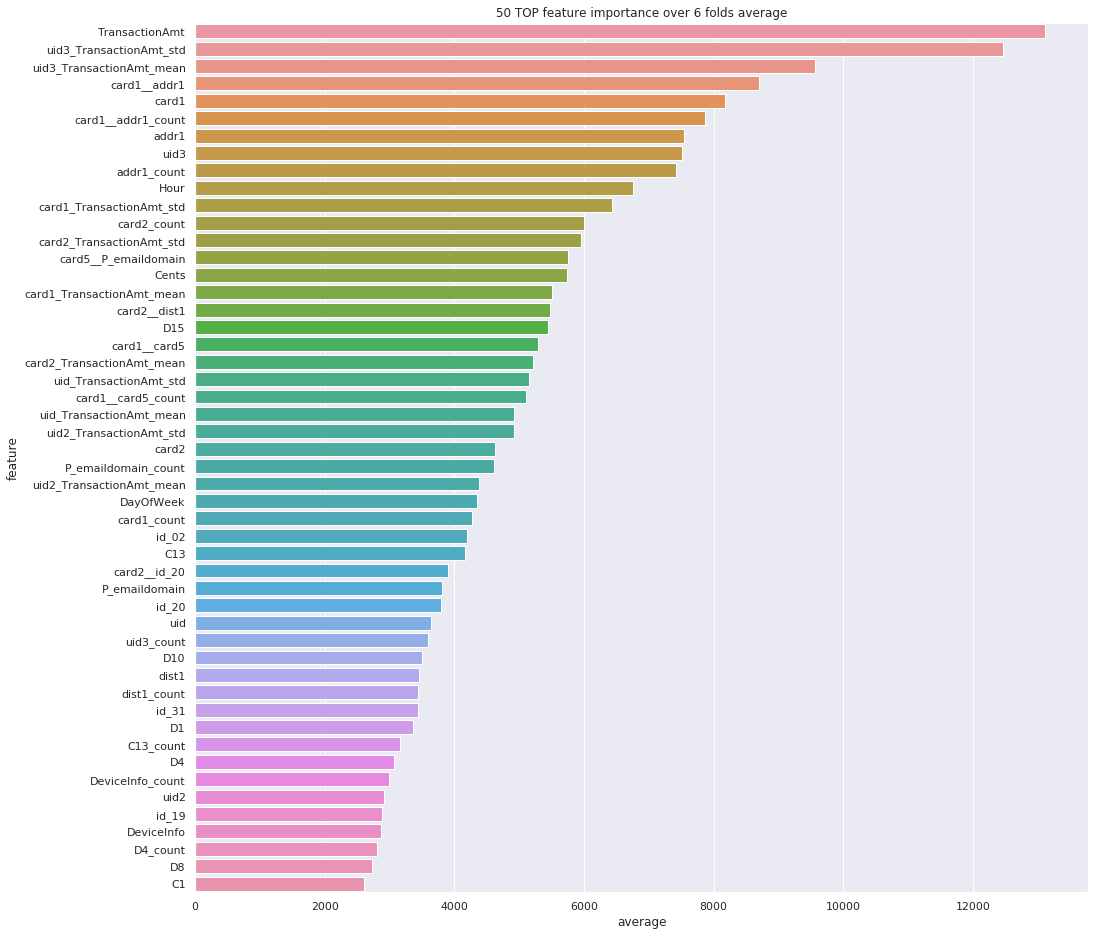

In [30]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(NFOLDS)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(NFOLDS));